# Lab 3: Policy Search

## Task

Write agents able to play [*Nim*](https://en.wikipedia.org/wiki/Nim), with an arbitrary number of rows and an upper bound $k$ on the number of objects that can be removed in a turn (a.k.a., *subtraction game*).

The player **taking the last object wins**.

* Task3.1: An agent using fixed rules based on *nim-sum* (i.e., an *expert system*)
* Task3.2: An agent using evolved rules
* Task3.3: An agent using minmax
* Task3.4: An agent using reinforcement learning

## Instructions

* Create the directory `lab3` inside the course repo 
* Put a `README.md` and your solution (all the files, code and auxiliary data if needed)

In [1]:
%load_ext autoreload
%autoreload 2

from task1_lib import gabriele, pure_random, fixed_rules_strategy
from task2_lib import run_GA, strategy_0, strategy_1, strategy_2
from task4_lib import task4_run
from nim_utils import evaluate, evaluate_GA, play_match

# Task 1

In [2]:
NUM_MATCHES = 100
NIM_SIZE = 10
K_SIZE = None

print(f"Win-rate against {gabriele.__name__}: {evaluate(fixed_rules_strategy, gabriele, NUM_MATCHES, NIM_SIZE, k_size=K_SIZE)}")
print(f"Win-rate against {pure_random.__name__}: {evaluate(fixed_rules_strategy, pure_random, NUM_MATCHES, NIM_SIZE, k_size=K_SIZE)}")


Win-rate against gabriele: 1.0
Win-rate against pure_random: 0.87


# Task 2

In [68]:
# Strategy 0
print(f"[info] - Strategy 0 results...")
genome_parameters = ["alpha", "beta", "gamma"]
num_generations = 150
best_genome = run_GA(genome_parameters, strategy_0, num_generations)

print(f"Win-rate against gabriele: {evaluate_GA(best_genome, strategy_0, gabriele, NUM_MATCHES, NIM_SIZE, k_size=K_SIZE)}")
print(f"Win-rate against pure_random: {evaluate_GA(best_genome, strategy_0, pure_random, NUM_MATCHES, NIM_SIZE, k_size=K_SIZE)}")


# Strategy 1
print(f"[info] - Strategy 1 results...")
genome_parameters = ["alpha", "beta"]
num_generations = 30
best_genome = run_GA(genome_parameters, strategy_1, num_generations)

print(f"Win-rate against gabriele: {evaluate_GA(best_genome, strategy_1, gabriele, NUM_MATCHES, NIM_SIZE, k_size=K_SIZE)}")
print(f"Win-rate against pure_random: {evaluate_GA(best_genome, strategy_1, pure_random, NUM_MATCHES, NIM_SIZE, k_size=K_SIZE)}")


# Strategy 2
print(f"[info] - Strategy 2 results...")
genome_parameters = ["alpha", "beta", "gamma", "percentage"]
num_generations = 30
best_genome = run_GA(genome_parameters, strategy_2, num_generations)

print(f"Win-rate against gabriele: {evaluate_GA(best_genome, strategy_2, gabriele, NUM_MATCHES, NIM_SIZE, k_size=K_SIZE)}")
print(f"Win-rate against pure_random: {evaluate_GA(best_genome, strategy_2, pure_random, NUM_MATCHES, NIM_SIZE, k_size=K_SIZE)}")

[info] - Strategy 0 results...
[info] - Start generating the population


100%|██████████| 50/50 [00:03<00:00, 15.22it/s]


[info] - Evolving...


100%|██████████| 150/150 [03:55<00:00,  1.57s/it]


[info] - Best genome found is {'alpha': 0.011386665687883157, 'beta': 0.9062171717087414, 'gamma': 0.9873926707644166} with fitness: (0.95, 0.6)
Win-rate against gabriele: 0.88
Win-rate against pure_random: 0.52
[info] - Strategy 1 results...
[info] - Start generating the population


100%|██████████| 50/50 [00:02<00:00, 23.87it/s]


[info] - Evolving...


100%|██████████| 30/30 [00:25<00:00,  1.17it/s]


[info] - Best genome found is {'alpha': 0.8522898164482559, 'beta': 0.2373071439533727} with fitness: (1.0, 0.99)
Win-rate against gabriele: 1.0
Win-rate against pure_random: 0.86
[info] - Strategy 2 results...
[info] - Start generating the population


100%|██████████| 50/50 [00:13<00:00,  3.79it/s]


[info] - Evolving...


100%|██████████| 30/30 [03:23<00:00,  6.79s/it]


[info] - Best genome found is {'alpha': 0.012787059560542713, 'beta': 0.09369813057952592, 'gamma': 0.9237723033079731, 'percentage': 0.3821294817321689} with fitness: 0.995
Win-rate against gabriele: 0.98
Win-rate against pure_random: 0.95


In [69]:
import random
from nimply import Nim


def challenge(genome0, strategy_0, genome1, strategy_1, num_matches=100, nim_size=10, k_size=None):
    won = 0

    for m in range(num_matches):
        nim = Nim(nim_size, k=k_size)
        player = random.randint(0, 1)
        while nim:
            if player == 0:
                ply = strategy_0(nim, genome0)
            else:
                ply = strategy_1(nim, genome1)
            nim.nimming(ply)
            player = 1 - player
        if player == 1:
            won += 1
    return won / num_matches

genome0 = {'alpha': 0.33806644070961167, 'beta': 0.8983983212868427, 'gamma': 0.9974669535320325}
genome1 = {'alpha': 0.8191618758747532, 'beta': 0.10484407005864857}

challenge(genome0, strategy_0, genome1, strategy_1)

# Task 3

In [3]:
from nimply import Nimply
from nimply import Nim
from copy import deepcopy

"""
Generic implementation

def minimax(currentpos,depth,maximizingplayer):
    if depth==0:
        return currentpos
    if maximizingplayer: #we want to get the max
        maxEval=-infinity
        for each child of position
            eval=minimax(child,depth-1,false)
            maxEval=max(maxEval,eval)
        return maxEval

    else
        minEval=+infinity
        for each child of position
            eval=minimax(minEval,eval)
            minEvail=min(minEval,eval)
        return minEval
"""

"""
With possible_new_states(),
you calculate the possible next states while making sure that a player can’t take more counters than those available on the board.
"""
def possible_moves(state: Nim):
    # retrieve all the possible moves
    #state is NIM so it is needed to explicitly use rows
    return [(r, o) for r, c in enumerate(state.rows) for o in range(1, c+1)]

def possible_new_states(state: Nim):
    # returns a list of outcome of all possible moves
    states = []
    #check available states
    for p in possible_moves(state):
        tmp = deepcopy(state)
        tmp.nimming(Nimply(p[0], p[1]))
        states.append(tmp)
    return states
"""
You evaluate a game position with evaluate().
If there are no counters left, then the function returns 1 if the maximizing player won the game and -1 if the other—minimizing—player won.
If the game isn’t over, execution will continue to the end of the function and implicitly return None.
"""
def evaluate(state, is_maximizing):
    if state == 0:
        return 1 if is_maximizing else -1

#understand the best possible move to do (highest in score)

#minmax strategy
def minimax(state: Nim, is_maximizing):
    #ending position
    if sum(r for r in state.rows) == 0:
        return -1 if is_maximizing else 1


    if is_maximizing:
        scores = [
            minimax(new_state, is_maximizing=False)
            for new_state in possible_new_states(state)
        ]
        return max(scores)
    else:
        scores = [
            minimax(new_state, is_maximizing=True)
            for new_state in possible_new_states(state)
        ]
        return min(scores)
#max_turn=is_maximizing

def minmax_strategy(state:Nim):
    for move in possible_moves(state):
        #from lecture code
        tmp = deepcopy(state)
        tmp.nimming(Nimply(move[0], move[1]))
        #calculate the score
        score = minimax(tmp, is_maximizing=False)
        if score > 0:
            break
    return Nimply(move[0], move[1])

#-------------------------- With alpha and beta pruning -----------------------------
"""
alpha will represent the minimum score that the maximizing player is ensured.
beta will represent the maximum score that the minimizing player is ensured.
"""

def minimax_pruning(state, is_maximizing,alpha=-0.5, beta=1):
    #ending position
    if sum(r for r in state.rows) == 0:
        return -1 if is_maximizing else 1

    scores = []
    for new_state in possible_new_states(state):
        scores.append(
            score := minimax_pruning(new_state, not is_maximizing, alpha, beta)
        )
        if is_maximizing:
            alpha = max(alpha, score)
        else:
            beta = min(beta, score)
        if beta <= alpha:
            break
    return (max if is_maximizing else min)(scores)

def minmax_strategy_pruning(state:Nim):
    for move in possible_moves(state):
        #from lecture code
        tmp = deepcopy(state)
        tmp.nimming(Nimply(move[0], move[1]))
        #calculate the score
        score = minimax_pruning(tmp, False)
        if score > 0:
            break
    return Nimply(move[0], move[1])

In [4]:
import logging
import random
from task1_lib import gabriele, pure_random, fixed_rules_strategy
import time
start_time = time.time()

logging.getLogger().setLevel(logging.DEBUG)

# strategy = (pure_random, minmax_best_move)
# strategy = (minmax_best_move, pure_random)
strategy = (pure_random, minmax_strategy)
# strategy = (minmax_best_move, optimal_strategy)

nim = Nim(3)

logging.debug(f"status: Initial board  -> {nim}")
player = 0
while nim:
    ply = strategy[player](nim)
    nim.nimming(ply)
    logging.debug(f"status: After player {player} -> {nim}")
    player = 1 - player
winner = 1 - player
logging.info(f"status: Player {winner} won!")


print("--- %s seconds ---" % (time.time() - start_time))

DEBUG:root:status: Initial board  -> <1 3 5>
DEBUG:root:status: After player 0 -> <0 3 5>
DEBUG:root:status: After player 1 -> <0 3 3>
DEBUG:root:status: After player 0 -> <0 1 3>
DEBUG:root:status: After player 1 -> <0 1 1>
DEBUG:root:status: After player 0 -> <0 0 1>
DEBUG:root:status: After player 1 -> <0 0 0>
INFO:root:status: Player 1 won!


--- 0.029001235961914062 seconds ---


# Task 4

0: 1/50
50: 26/50
100: 20/50
150: 25/50
200: 29/50
250: 30/50
300: 20/50
350: 24/50
400: 28/50
450: 18/50
500: 24/50
550: 25/50
600: 22/50
650: 23/50
700: 25/50
750: 25/50
800: 23/50
850: 27/50
900: 22/50
950: 23/50
1000: 24/50
1050: 22/50
1100: 19/50
1150: 23/50
1200: 21/50
1250: 23/50
1300: 26/50
1350: 25/50
1400: 25/50
1450: 20/50
1500: 28/50
1550: 23/50
1600: 18/50
1650: 32/50
1700: 26/50
1750: 22/50
1800: 25/50
1850: 27/50
1900: 25/50
1950: 22/50
2000: 29/50
2050: 28/50
2100: 27/50
2150: 24/50
2200: 25/50
2250: 27/50
2300: 23/50
2350: 21/50
2400: 22/50
2450: 29/50
2500: 24/50
2550: 28/50
2600: 30/50
2650: 27/50
2700: 20/50
2750: 23/50
2800: 24/50
2850: 31/50
2900: 32/50
2950: 25/50
3000: 25/50
3050: 21/50
3100: 22/50
3150: 26/50
3200: 23/50
3250: 28/50
3300: 26/50
3350: 27/50
3400: 25/50
3450: 26/50
3500: 23/50
3550: 32/50
3600: 24/50
3650: 30/50
3700: 23/50
3750: 20/50
3800: 24/50
3850: 26/50
3900: 33/50
3950: 17/50
4000: 29/50
4050: 24/50
4100: 23/50
4150: 22/50
4200: 19/50
4250

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\aless\\AppData\\Local\\pypoetry\\Cache\\virtualenvs\\lab3-0gnANNKr-py3.10\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\aless\\AppData\\Local\\pypoetry\\Cache\\virtualenvs\\lab3-0gnANNKr-py3.10\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.334999999999

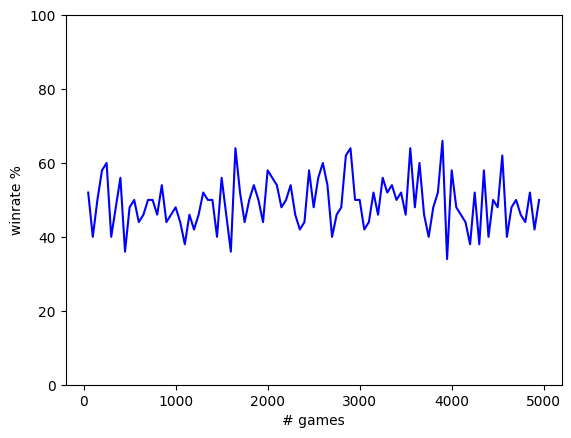

In [5]:
task4_run()

## Oversimplified match

In [70]:
play_match(fixed_rules_strategy, pure_random, 10, k_size=None)